In [1]:
import pickle
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore')
from platform import python_version
print(python_version())

3.9.2


# Read Inter-Subject Results

In [2]:
resultsDict = {}
for file in os.listdir('./outputs/classification/inter-subject'):
    infile = open('./outputs/classification/inter-subject/' + file, 'rb')
    resultsDict['{}'.format(file)] = pickle.load(infile)
    infile.close()

In [ ]:
for key in resultsDict.keys():
    Y_true_pred = resultsDict[key]['TruePredY']
    best_accuracy = accuracy_score(Y_true_pred.values[:,0], Y_true_pred.values[:,1])
#     print('Test accuracy for {} is: {:0.2f}'.format(key, best_accuracy))

## Save Mean of Metrics for all Runs

In [45]:
all_reports_df = pd.DataFrame(columns=['fold', 'window_length', 'feature', 'model', 'electricPanel', 'hoist', 'ladder', 'lift', 'overhead', 'push', 'sit', 'stand', 'type', 'walk'])
for key in resultsDict.keys():
    truePredY = resultsDict[key]['TruePredY']
    reports = classification_report(truePredY['True'], truePredY['Predicted'], output_dict=True)
    reports_df = pd.DataFrame(reports)
#     reports_df.loc['support'] = reports_df.loc['support'].astype(int).astype(str)
    reports_df = reports_df.drop(columns=['macro avg', 'weighted avg'], index='support')
    reports_df['fold'] = key[4]
    if '320' in key:
        reports_df['window_length'] = 10
    elif '128' in key:
        reports_df['window_length'] = 4
        
    if 'FrequencyAll_' in key:
        reports_df['feature'] = 'Frequency'
    elif 'Time_' in key:
        reports_df['feature'] = 'Time'
    elif 'TimeFrequency_' in key:
        reports_df['feature'] = 'Time Frequency'
        
    if 'KNN' in key:
        reports_df['model'] = 'k-NN'
    elif 'SVC' in key:
        reports_df['model'] = 'SVM'
    elif 'RandomForest' in key:
        reports_df['model'] = 'RF'
        
    all_reports_df = pd.concat([all_reports_df, reports_df], axis=0)
all_reports_df = all_reports_df.reset_index().rename(columns={'index':'measure', 'accuracy': 'overall_accuracy'})
mean_df = all_reports_df.groupby(['window_length', 'feature', 'model', 'measure']).mean().reset_index()
mean_df['overall_accuracy_stdev'] = all_reports_df.groupby(['window_length', 'feature', 'model', 'measure']).std()['overall_accuracy'].values
mean_df = mean_df.round(decimals=2)
mean_df.to_csv('outputs/tables/inter-subject_mean_metrics.csv')
# mean_df

# Mean Accuracy and Plots

In [32]:
columns = ['test_set', 'window_len', 'feature_set', 'classifier', 'overall_accuracy']
accuracy_df = pd.DataFrame(columns=columns)

for key in resultsDict.keys():
    tmp_str_split = key[:-7].split('_')
    test_set = tmp_str_split[0][-1]
    feature = tmp_str_split[1]
    classifier = tmp_str_split[2]
    window_length = tmp_str_split[3]
    
    Y_true_pred = resultsDict[key]['TruePredY']
    overall_accuracy = accuracy_score(Y_true_pred['True'], Y_true_pred['Predicted'])
    
    accuracy_df = accuracy_df.append({'test_set': test_set, 'window_len': window_length, 'feature_set': feature, 'classifier': classifier, 'overall_accuracy': overall_accuracy},
                                     ignore_index=True)

In [46]:
mean_results_df = accuracy_df.groupby(['window_len', 'feature_set', 'classifier']).mean().reset_index()
mean_results_df['stdev'] = accuracy_df.groupby(['window_len', 'feature_set', 'classifier']).std().values
mean_results_df.to_csv('outputs/tables/inter-subject_mean_accuracy.csv')
accuracy_df

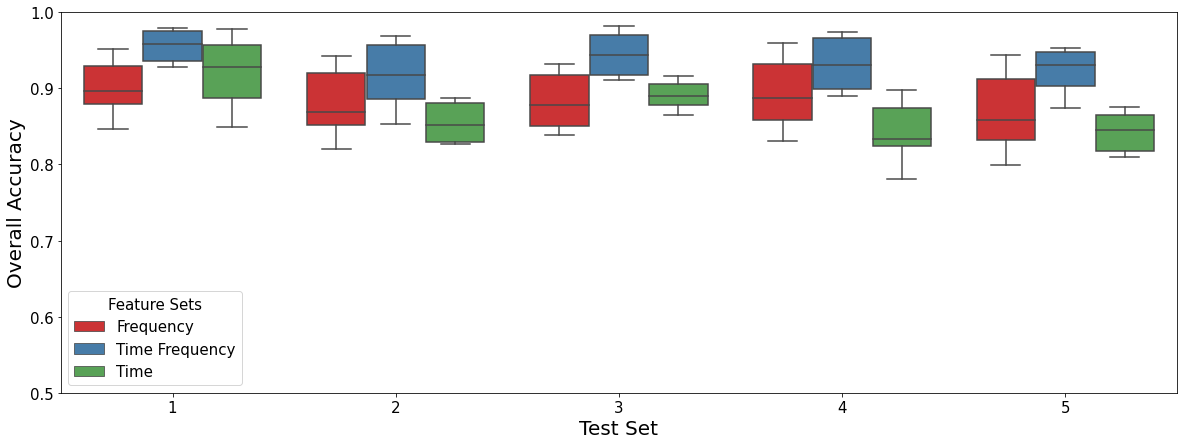

In [41]:
f, ax = plt.subplots(1, figsize=(20, 7))
sns.boxplot(x='test_set', y='overall_accuracy', hue='feature_set', data=accuracy_df, ax=ax, palette='Set1')
ax.set_ylabel('Overall Accuracy', fontsize=20)
ax.set_xlabel('Test Set', fontsize=20)
ax.set_ylim([0.5, 1])
ax.tick_params(axis='both', which='major', labelsize=15)
lgnd = ax.legend(title='Feature Sets', fontsize=15)
lgnd.get_title().set_fontsize('15')
lgnd.texts[0].set_text('Frequency')
lgnd.texts[1].set_text('Time Frequency')
lgnd.texts[2].set_text('Time')
f.savefig('outputs/figures/OverallAccuracy.png')
plt.show()

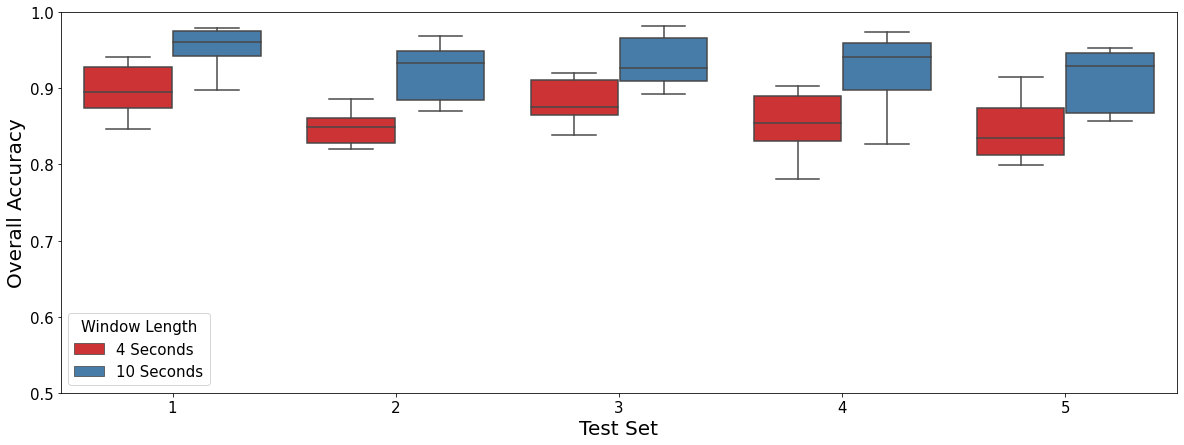

In [42]:
f, ax = plt.subplots(1, figsize=(20, 7))
sns.boxplot(x='test_set', y='overall_accuracy', hue='window_len', data=accuracy_df, ax=ax, palette='Set1')
ax.set_ylabel('Overall Accuracy', fontsize=20)
ax.set_xlabel('Test Set', fontsize=20)
ax.set_ylim([0.5, 1])
ax.tick_params(axis='both', which='major', labelsize=15)
lgnd = ax.legend(title='Window Length', fontsize=15)
lgnd.get_title().set_fontsize('15')
lgnd.texts[0].set_text('4 Seconds')
lgnd.texts[1].set_text('10 Seconds')
plt.show()

## Tests Subjects

> `Test Set 1`: **26, 32, 21, 9, 13, 20, 12, 24**

> `Test Set 2`: **41, 37, 42, 35, 43, 11, 23, 39**  --> 1 left handed

> `Test Set 3`: **14, 22, 18, 17, 28, 33, 38**

> `Test Set 4`: **34, 19, 44, 31, 29, 40, 27**  --> 1 left handed

> `Test Set 5`: **16, 30, 8, 10, 15, 25, 36**


**Left handed subjects: 19 & 35 subject**

# Two Way ANOVA for Classifiers and Feature Sets and Post-hoc Analysis

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## All Window Lengths

In [7]:
model = ols('overall_accuracy ~ C(classifier) + C(feature_set) + C(classifier):C(feature_set)', data=accuracy_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(classifier),0.013198,2.0,3.871386,2.478890e-02
C(feature_set),0.067041,2.0,19.665882,1.092048e-07
C(classifier):C(feature_set),0.006883,4.0,1.009555,4.075045e-01
Residual,0.138065,81.0,NaN,NaN


### Tukey Test (Feature Sets)

In [8]:
m_comp = pairwise_tukeyhsd(endog=accuracy_df['overall_accuracy'], groups=accuracy_df['feature_set'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FrequencyAll,Time,-0.0151,0.3629,-0.0413,0.0112,False
1,FrequencyAll,TimeFrequency,0.0489,0.0010,0.0226,0.0751,True
2,Time,TimeFrequency,0.0639,0.0010,0.0377,0.0902,True


### Tukey Test (Classifiers)

In [9]:
m_comp = pairwise_tukeyhsd(endog=accuracy_df['overall_accuracy'], groups=accuracy_df['classifier'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RandomForest,0.0159,0.4288,-0.0145,0.0463,False
1,KNN,SVC,0.0296,0.0576,-0.0008,0.0600,False
2,RandomForest,SVC,0.0137,0.5312,-0.0167,0.0441,False


## 10 Seconds Window Lengths

In [10]:
accuracy_10sec_df = accuracy_df[accuracy_df['window_len']=='320']

model = ols('overall_accuracy ~ C(classifier) + C(feature_set) + C(classifier):C(feature_set)', data=accuracy_10sec_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(classifier),0.007783,2.0,6.035505,5.489673e-03
C(feature_set),0.035423,2.0,27.470017,5.699713e-08
C(classifier):C(feature_set),0.004962,4.0,1.923973,1.275482e-01
Residual,0.023211,36.0,NaN,NaN


### Pairwise Tukey Test (Feature Sets)

In [11]:
m_comp = pairwise_tukeyhsd(endog=accuracy_10sec_df['overall_accuracy'], groups=accuracy_10sec_df['feature_set'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FrequencyAll,Time,-0.0251,0.0599,-0.0511,0.0009,False
1,FrequencyAll,TimeFrequency,0.0429,0.0010,0.0169,0.0688,True
2,Time,TimeFrequency,0.0680,0.0010,0.0420,0.0939,True


### Pairwise Tukey Test (Classifiers)

In [12]:
m_comp = pairwise_tukeyhsd(endog=accuracy_10sec_df['overall_accuracy'], groups=accuracy_10sec_df['classifier'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RandomForest,0.023,0.2493,-0.0115,0.0575,False
1,KNN,SVC,0.031,0.0857,-0.0035,0.0656,False
2,RandomForest,SVC,0.008,0.8239,-0.0265,0.0426,False


## 4 Seconds Window Lengths

In [13]:
accuracy_4sec_df = accuracy_df[accuracy_df['window_len']=='128']

model = ols('overall_accuracy ~ C(classifier) + C(feature_set) + C(classifier):C(feature_set)', data=accuracy_4sec_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(classifier),0.006253,2.0,4.713828,1.519424e-02
C(feature_set),0.033149,2.0,24.988528,1.565160e-07
C(classifier):C(feature_set),0.002337,4.0,0.880840,4.850895e-01
Residual,0.023879,36.0,NaN,NaN


### Tukey Test (Feature Sets)

In [14]:
m_comp = pairwise_tukeyhsd(endog=accuracy_4sec_df['overall_accuracy'], groups=accuracy_4sec_df['feature_set'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FrequencyAll,Time,-0.0050,0.8639,-0.0297,0.0196,False
1,FrequencyAll,TimeFrequency,0.0549,0.0010,0.0302,0.0796,True
2,Time,TimeFrequency,0.0599,0.0010,0.0353,0.0846,True


### Tukey Test (Classifiers)

In [15]:
m_comp = pairwise_tukeyhsd(endog=accuracy_4sec_df['overall_accuracy'], groups=accuracy_4sec_df['classifier'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RandomForest,0.0089,0.7776,-0.0245,0.0422,False
1,KNN,SVC,0.0282,0.1114,-0.0051,0.0616,False
2,RandomForest,SVC,0.0194,0.3457,-0.0140,0.0527,False
